In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sehriyarmemmedli/facecropped-glasses-vs-noglasses-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'facecropped-glasses-vs-noglasses-dataset' dataset.
Path to dataset files: /kaggle/input/facecropped-glasses-vs-noglasses-dataset


In [ ]:
# Imports y setup
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Versión de TF
print("TensorFlow:", tf.__version__)

# Semilla para reproducibilidad
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Path del kaggle
DATA_DIR = Path(path)
print("DATA_DIR:", DATA_DIR)

# Comprobamos que exista
assert DATA_DIR.exists(), "No encuentro el directorio del dataset"

TensorFlow: 2.19.0
DATA_DIR: /kaggle/input/facecropped-glasses-vs-noglasses-dataset


In [ ]:
# Conteo por split (train/validation/test) y por clase
from pathlib import Path

train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "val"
test_dir  = DATA_DIR / "test"

assert train_dir.exists(), "No se encontró la carpeta 'train/'."
assert val_dir.exists(),   "No se encontró la carpeta 'val/'."
assert test_dir.exists(),  "No se encontró la carpeta 'test/'."

IMG_EXTS = {".jpg", ".jpeg", ".png"}

def count_images_in_subdirs(root: Path):
    counts = {}
    for sub in sorted([d for d in root.iterdir() if d.is_dir()]):
        n = sum(1 for p in sub.rglob("*") if p.suffix.lower() in IMG_EXTS)
        counts[sub.name] = n
    total = sum(counts.values())
    return counts, total

def print_split_counts(name, dirpath):
    cls_counts, total = count_images_in_subdirs(dirpath)
    print(f"{name}: total={total}")
    for cls, n in cls_counts.items():
        print(f"  - {cls}: {n}")
    return cls_counts, total

print("=== Conteos por split ===")
train_counts, train_total = print_split_counts("train", train_dir)
val_counts,   val_total   = print_split_counts("validation", val_dir)
test_counts,  test_total  = print_split_counts("test", test_dir)


=== Conteos por split ===
train: total=76049
  - with_glasses: 27513
  - without_glasses: 48536
validation: total=15210
  - with_glasses: 5503
  - without_glasses: 9707
test: total=3803
  - with_glasses: 1376
  - without_glasses: 2427


Found 76049 files belonging to 2 classes.
Found 15210 files belonging to 2 classes.
Found 3803 files belonging to 2 classes.
Clases detectadas: ['with_glasses', 'without_glasses']


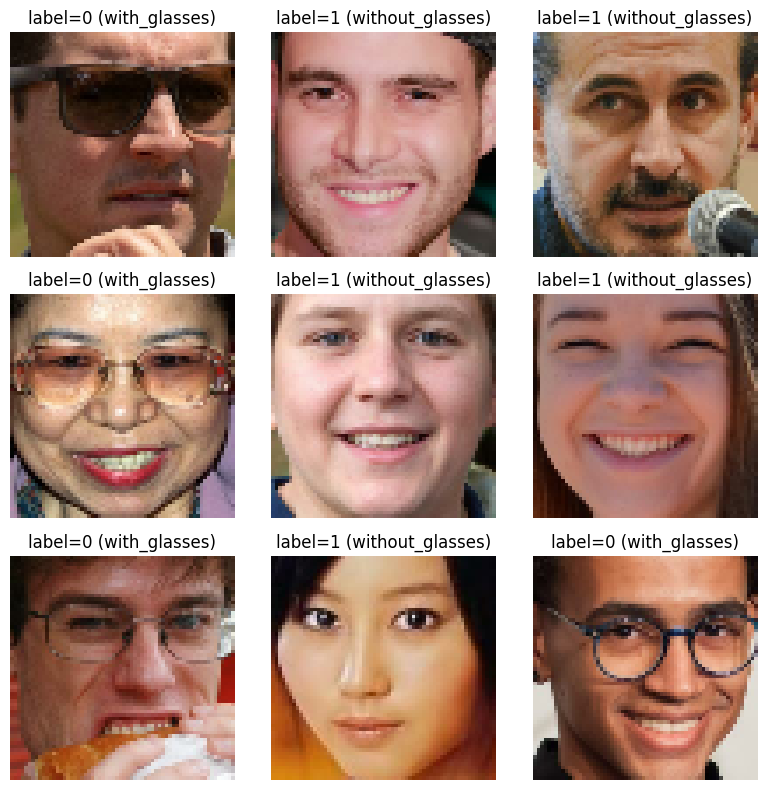

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE   = (64, 64)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

def make_ds(dirpath, shuffle, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
    return tf.keras.utils.image_dataset_from_directory(
        directory=dirpath,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED
    )

train_ds = make_ds(train_dir, shuffle=True)
val_ds   = make_ds(val_dir,   shuffle=False)
test_ds  = make_ds(test_dir,  shuffle=False)

class_names = train_ds.class_names
print("Clases detectadas:", class_names)

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Vista de un batch
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        lbl = int(labels[i].numpy()[0])
        plt.title(f"label={lbl} ({class_names[lbl]})")
        plt.axis("off")
plt.tight_layout()
plt.show()


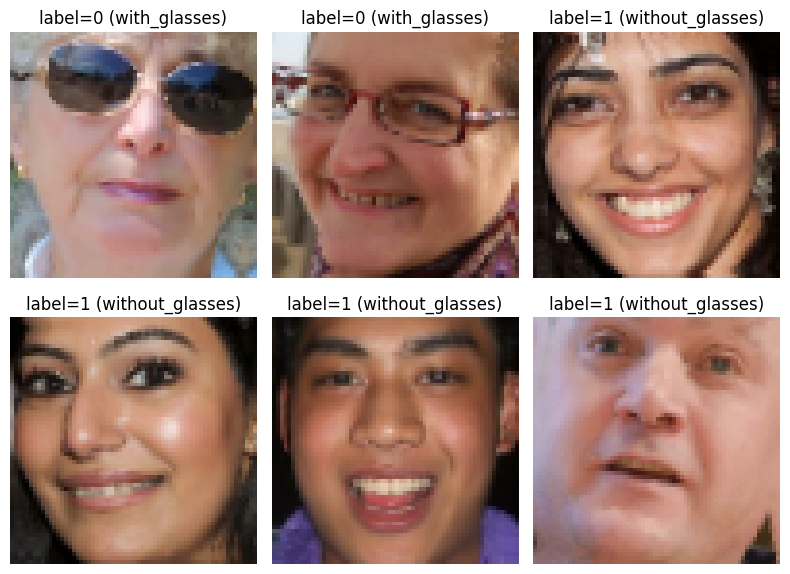

In [ ]:
from tensorflow.keras import layers

# Normalización a [0,1]
normalization = layers.Rescaling(1./255)

# Aumentos ligeros(flip y rotación pequeña)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.05, seed=SEED),
], name="data_augmentation")

# Aplicar normalización a los datasets
def with_normalization(ds):
    return ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

train_ds_norm = with_normalization(train_ds)
val_ds_norm   = with_normalization(val_ds)
test_ds_norm  = with_normalization(test_ds)

# Verificación rápida (imágenes tras augmentation)
import matplotlib.pyplot as plt

sample_batch = next(iter(train_ds.take(1)))
images_raw, labels_raw = sample_batch

plt.figure(figsize=(8,6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    aug_img = data_augmentation(images_raw)[i].numpy()
    plt.imshow(aug_img.astype("uint8"))
    plt.title(f"label={int(labels_raw[i].numpy()[0])} ({class_names[int(labels_raw[i].numpy()[0])]})")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

INPUT_SHAPE = IMG_SIZE + (3,)  # (64, 64, 3)

def build_simple_cnn():
    model = Sequential([
        Input(shape=INPUT_SHAPE),

        # Data augmentation
        data_augmentation,

        # Bloque 1
        Conv2D(16, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Bloque 2
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        # Bloque 3
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # binario
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_simple_cnn()
model.summary()

# Callbacks para el entrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reducir LR si la val_loss se estanca
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Guardar el mejor modelo durante el entrenamiento
checkpoint_path = "best_glasses_classifier.keras"  # archivo local en Colab
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697 (100.38 KB)

 Trainable params: 25,697 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

EPOCHS = 10

history = model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# History a DataFrame
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

# Gráfica de pérdida
ax = hist_df[['loss','val_loss']].plot(title='Loss vs Epochs')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
plt.show()

# Gráfica de accuracy
ax = hist_df[['accuracy','val_accuracy']].plot(title='Accuracy vs Epochs')
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy')
plt.show()

# Cargar el mejor checkpoint
best_model = tf.keras.models.load_model(checkpoint_path)
print("Best model loaded from:", checkpoint_path)

Epoch 1/30
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7394 - loss: 0.5190
Epoch 1: val_loss improved from inf to 0.11361, saving model to best_glasses_classifier.keras
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 394s 157ms/step - accuracy: 0.7394 - loss: 0.5190 - val_accuracy: 0.9606 - val_loss: 0.1136 - learning_rate: 0.0010
Epoch 2/30
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9476 - loss: 0.1430
Epoch 2: val_loss improved from 0.11361 to 0.09834, saving model to best_glasses_classifier.keras
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 338s 142ms/step - accuracy: 0.9476 - loss: 0.1430 - val_accuracy: 0.9664 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 3/30
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9642 - loss: 0.0992
Epoch 3: val_loss improved from 0.09834 to 0.05612, saving model to best_glasses_classifier.keras
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 369s 137ms/step - accuracy: 0.9642 - loss: 0.0992 - val_accuracy: 0.9814 - val_loss: 0.0561 - learning_rate: 0.0010

KeyboardInterrupt: 

119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.9892 - loss: 0.0306
Test loss: 0.0264
Test accuracy: 0.9916


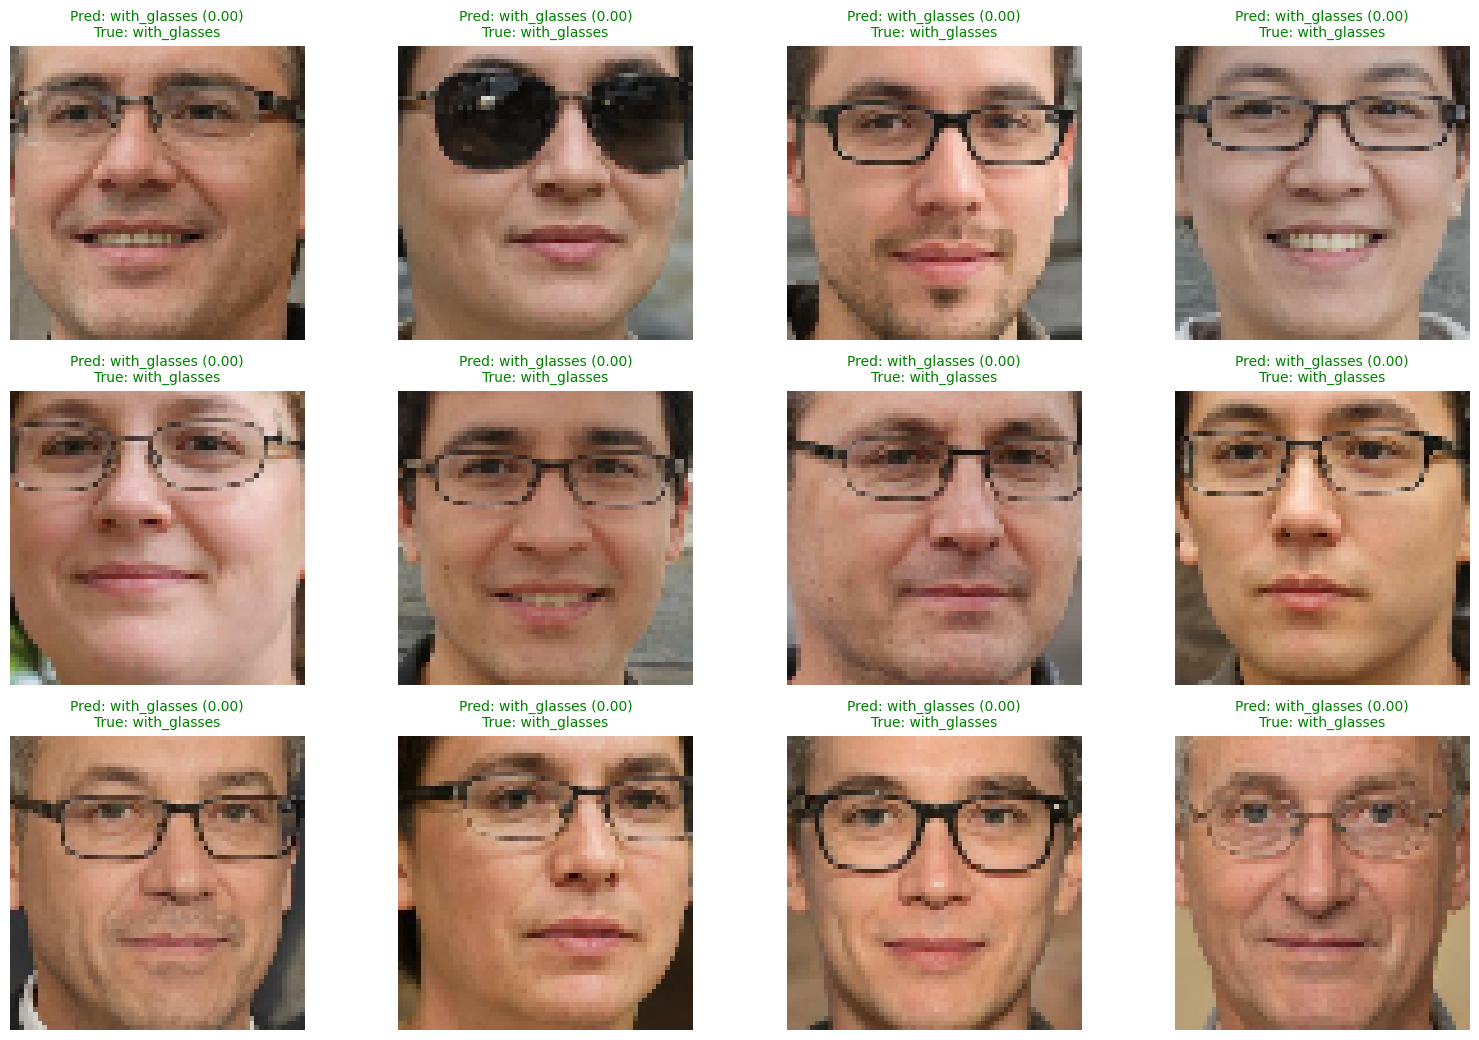

In [ ]:
# Evaluación y visualización de predicciones
import numpy as np
import matplotlib.pyplot as plt

# Evaluación
test_loss, test_acc = best_model.evaluate(test_ds_norm, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Función para mostrar N predicciones del test
def show_test_predictions(model, test_ds, class_names, n=12):
    # Recolectar un batch grande (o varios) para muestreo simple
    images_list, labels_list = [], []
    for images, labels in test_ds.take(2):  # 2 batches
        images_list.append(images)
        labels_list.append(labels)
    images = tf.concat(images_list, axis=0)
    labels = tf.concat(labels_list, axis=0)

    # Predicciones
    probs = model.predict(images, verbose=0).ravel()  # shape (batch,)
    preds = (probs >= 0.5).astype(int)

    # n índices aleatorios
    idxs = np.random.choice(len(images), size=min(n, len(images)), replace=False)

    cols = 4
    rows = int(np.ceil(len(idxs)/cols))
    plt.figure(figsize=(4*cols, 3.5*rows))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        img = images[idx].numpy()
        true_lbl = int(labels[idx].numpy()[0])
        pred_lbl = int(preds[idx])
        conf = probs[idx]

        plt.imshow((img*255).astype("uint8"))  # imágenes ya normalizadas -> a [0,255] para mostrar
        title = f"Pred: {class_names[pred_lbl]} ({conf:.2f})\nTrue: {class_names[true_lbl]}"
        color = "green" if pred_lbl == true_lbl else "red"
        plt.title(title, color=color, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Mostrar algunas predicciones
show_test_predictions(best_model, test_ds_norm, class_names, n=12)


Cargado: sequential
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9892 - loss: 0.0306
Test loss: 0.0264
Test acc : 0.9916


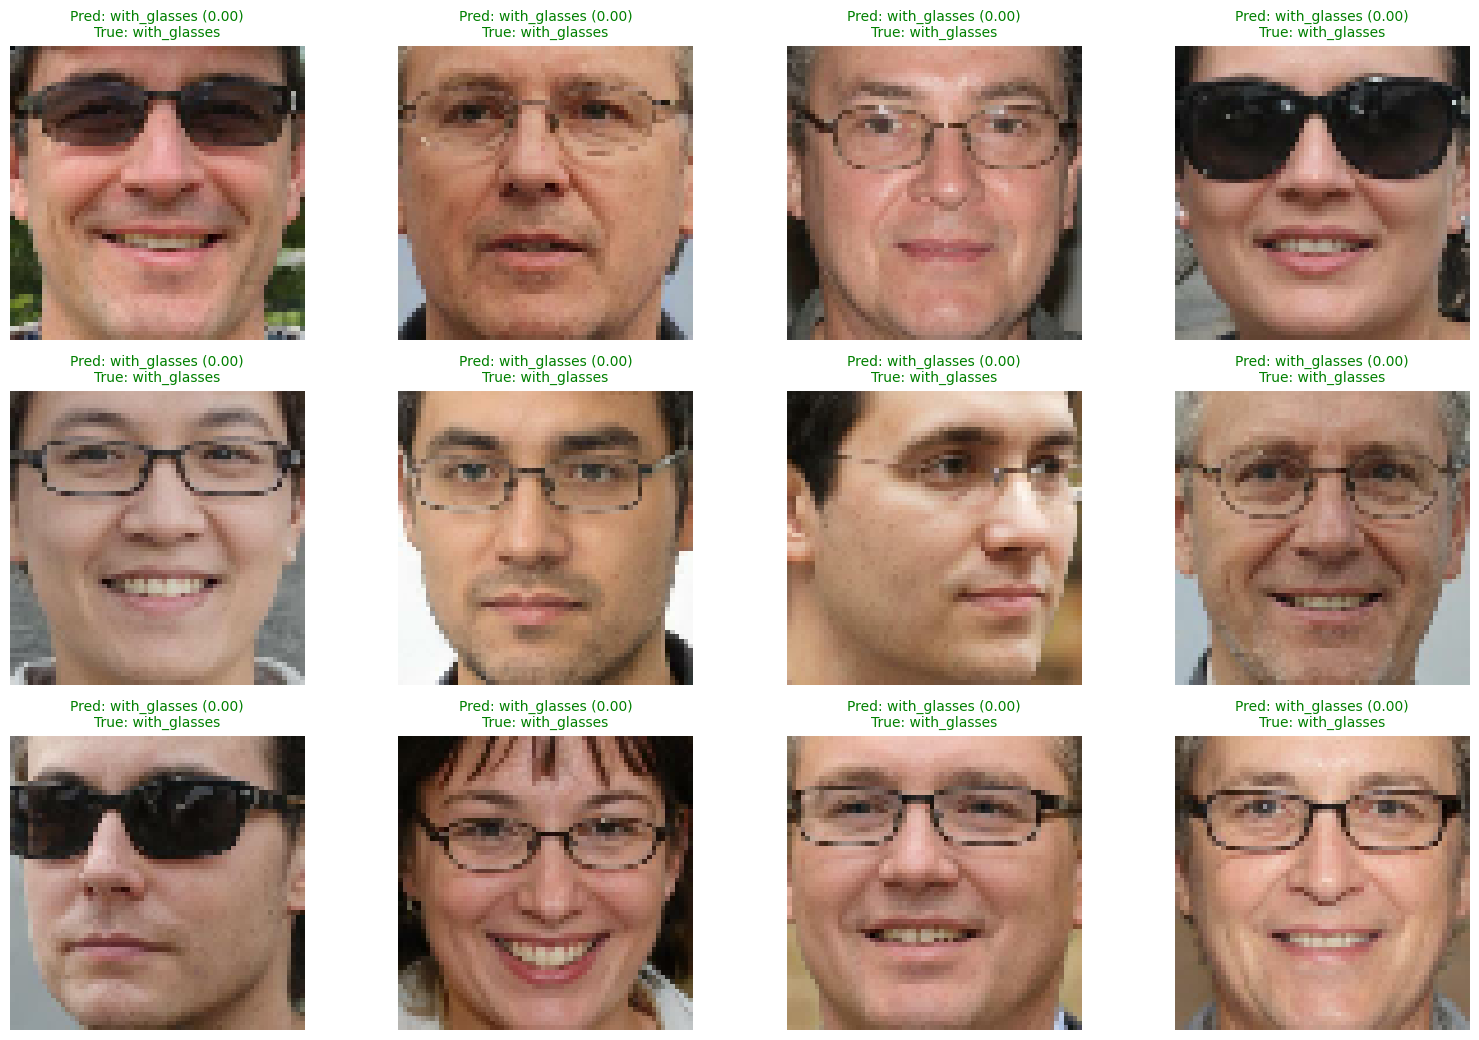

In [ ]:
# Cargar el mejor modelo
import tensorflow as tf

best_model = tf.keras.models.load_model("best_glasses_classifier.keras")
print("Cargado:", best_model.name if hasattr(best_model, "name") else "best_glasses_classifier")

# Evalúa en test
test_loss, test_acc = best_model.evaluate(test_ds_norm, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc:.4f}")

# Muestra predicciones
show_test_predictions(best_model, test_ds_norm, class_names, n=12)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Crea carpeta si no existe
save_path = "/content/drive/MyDrive/glasses_classifier/best_glasses_classifier.keras"
!mkdir -p "/content/drive/MyDrive/glasses_classifier"

# Guardar modelo final
best_model.save(save_path)
print(" Modelo guardado en:", save_path)

Mounted at /content/drive
 Modelo guardado en: /content/drive/MyDrive/glasses_classifier/best_glasses_classifier.keras
